# Kaggle Doppelgänger Detector: Find Your Data Twin

#### Objective
The goal of this project is to identify the most similar users on Kaggle based on their activity, 
achievements, kernel contributions, and competition performance. We call this your Kaggle Doppelgänger,
someone whose Kaggle journey mirrors your own!

#### Problem Statement
Kaggle hosts millions of data scientists with diverse experiences and engagement levels. But what if we could:

Find users who are most similar to you?

Benchmark yourself realistically using similar profiles?

Recommend mentors or peers based on shared patterns?

This project solves that using feature engineering + cosine similarity on Meta Kaggle data.



#### Datasets Used (from Meta Kaggle)
Users.csv
UserAchievements.csv
Kernels.csv
KernelVersions.csv
Competitions.csv
Submissions.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/META_KAGGLE/Users.csv'


In [ ]:
## Chunk-wise ingestion

In [ ]:
import pandas as pd

chunk_size = 100000
chunks = pd.read_csv('/content/drive/MyDrive/META_KAGGLE/Users.csv', chunksize=chunk_size)


for chunk in chunks:
    df = chunk.copy()
    break


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Id                     100000 non-null  int64 
 1   UserName               100000 non-null  object
 2   DisplayName            99991 non-null   object
 3   RegisterDate           100000 non-null  object
 4   PerformanceTier        100000 non-null  int64 
 5   Country                51006 non-null   object
 6   LocationSharingOptOut  100000 non-null  bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 4.7+ MB


In [ ]:
df.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,LocationSharingOptOut
0,1,kaggleteam,Kaggle Team,03/24/2011,5,NaN,False
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,2,United States,False
2,381,iguyon,Isabelle,01/29/2010,2,United States,False
3,383,davidstephan,David Stephan,02/01/2010,0,Australia,False
4,384,gabewarren,Gabe Warren,02/02/2010,0,Australia,False


In [ ]:
df.isnull().sum()

,0
Id,0
UserName,0
DisplayName,9
RegisterDate,0
PerformanceTier,0
Country,48994
LocationSharingOptOut,0


In [ ]:
df.describe()

,Id,PerformanceTier
count,100000.000000,100000.000000
mean,55172.429810,0.186290
std,31458.070918,0.467812
min,1.000000,0.000000
25%,27893.750000,0.000000
50%,55703.500000,0.000000
75%,82414.250000,0.000000
max,108963.000000,5.000000


In [ ]:
df = df.dropna(subset=['DisplayName'])


In [ ]:
df['Country'] = df['Country'].fillna('Unknown')


In [ ]:
df['RegisterDate'] = pd.to_datetime(df['RegisterDate'], format='%m/%d/%Y', errors='coerce')


In [ ]:
tier_map = {0: 'Novice', 1: 'Contributor', 2: 'Expert', 3: 'Master', 4: 'Grandmaster'}
df['TierLabel'] = df['PerformanceTier'].map(tier_map)


In [ ]:
df = df.drop(columns=['LocationSharingOptOut'])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99991 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Id               99991 non-null  int64         
 1   UserName         99991 non-null  object        
 2   DisplayName      99991 non-null  object        
 3   RegisterDate     99991 non-null  datetime64[ns]
 4   PerformanceTier  99991 non-null  int64         
 5   Country          99991 non-null  object        
 6   TierLabel        99986 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 6.1+ MB


In [ ]:
print(df['RegisterDate'].head(10))
print(df['RegisterDate'].isna().sum())

0   2011-03-24
1   2010-01-20
2   2010-01-29
3   2010-02-01
4   2010-02-02
5   2010-02-02
6   2010-02-02
7   2010-02-02
8   2010-02-03
9   2010-02-03
Name: RegisterDate, dtype: datetime64[ns]
0


In [ ]:
print(df['TierLabel'].head(10))
print(df['TierLabel'].isna().sum())

0            NaN
1         Expert
2         Expert
3         Novice
4         Novice
5         Novice
6         Novice
7         Novice
8         Novice
9    Contributor
Name: TierLabel, dtype: object
5


In [ ]:
df['AccountAge'] = (pd.Timestamp.now() - df['RegisterDate']).dt.days


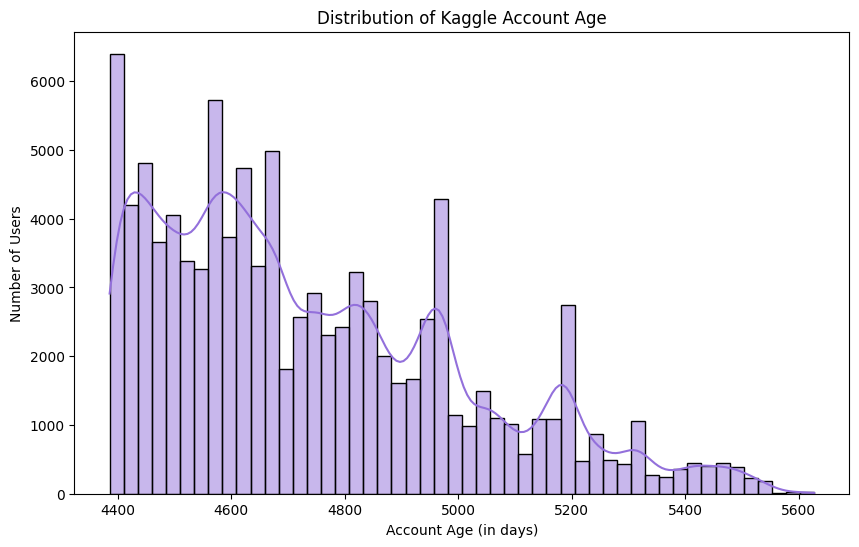

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['AccountAge'], bins=50, kde=True, color='mediumpurple')
plt.title('Distribution of Kaggle Account Age')
plt.xlabel('Account Age (in days)')
plt.ylabel('Number of Users')
plt.show()


<ipython-input-18-2680504352>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tier_group, x='PerformanceTier', y='AccountAge', palette='mako')


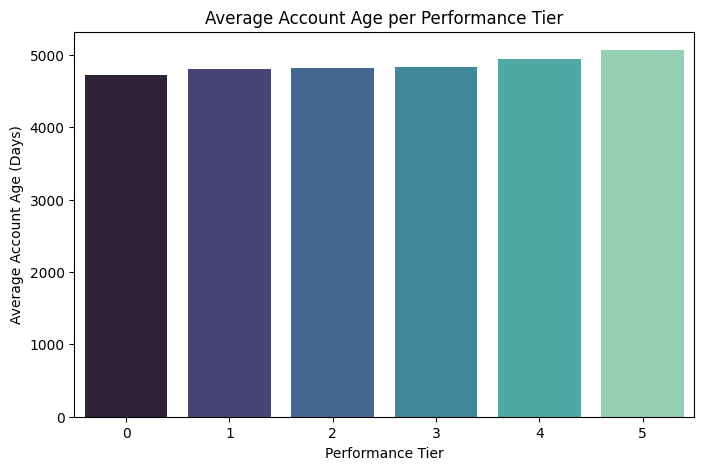

In [ ]:
tier_group = df.groupby('PerformanceTier')['AccountAge'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=tier_group, x='PerformanceTier', y='AccountAge', palette='mako')
plt.title('Average Account Age per Performance Tier')
plt.xlabel('Performance Tier')
plt.ylabel('Average Account Age (Days)')
plt.show()


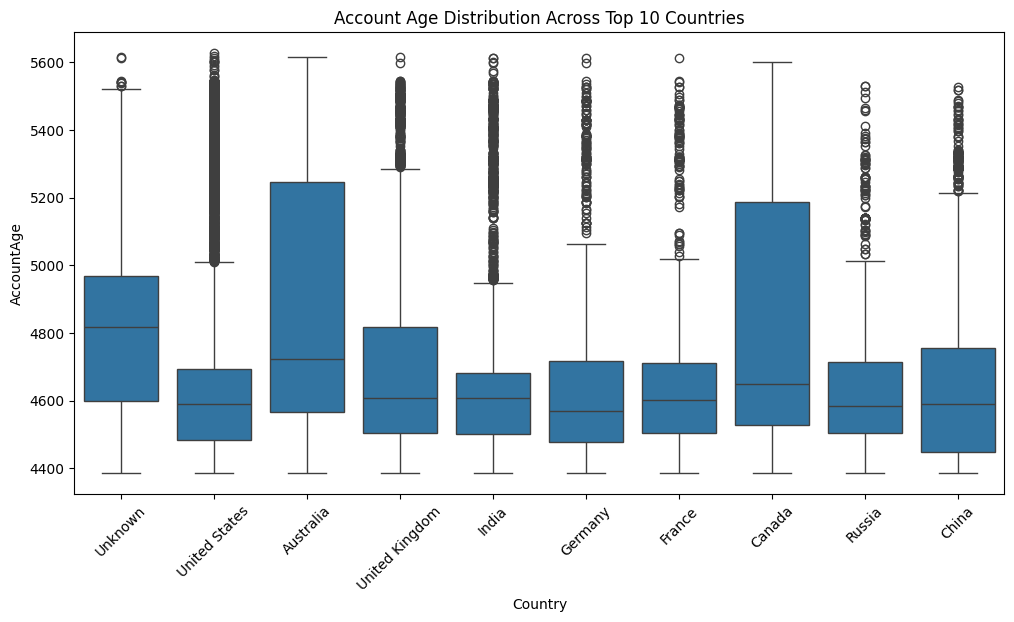

In [ ]:
top_countries = df['Country'].value_counts().head(10).index
country_df = df[df['Country'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.boxplot(data=country_df, x='Country', y='AccountAge')
plt.title('Account Age Distribution Across Top 10 Countries')
plt.xticks(rotation=45)
plt.show()


In [ ]:
file_path = '/content/drive/MyDrive/META_KAGGLE/UserAchievements.csv'

In [ ]:
chunk_reader = pd.read_csv(file_path, chunksize=100000)

# For now, let’s just look at the first chunk
first_chunk = next(chunk_reader)
first_chunk.head()


,Id,UserId,AchievementType,Tier,TierAchievementDate,Points,CurrentRanking,HighestRanking,TotalGold,TotalSilver,TotalBronze
0,3739827,381,Scripts,1,07/15/2016,0,NaN,NaN,0,0,0
1,3916403,383,Competitions,0,07/15/2016,0,NaN,NaN,0,0,0
2,3916404,384,Competitions,0,07/15/2016,0,NaN,NaN,0,0,0
3,3916405,385,Competitions,0,07/15/2016,0,NaN,NaN,0,0,0
4,3916406,386,Competitions,0,07/15/2016,0,NaN,NaN,0,0,0


In [ ]:
first_chunk.info()
first_chunk.describe()
first_chunk.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id                   100000 non-null  int64  
 1   UserId               100000 non-null  int64  
 2   AchievementType      100000 non-null  object 
 3   Tier                 100000 non-null  int64  
 4   TierAchievementDate  100000 non-null  object 
 5   Points               100000 non-null  int64  
 6   CurrentRanking       1780 non-null    float64
 7   HighestRanking       1792 non-null    float64
 8   TotalGold            100000 non-null  int64  
 9   TotalSilver          100000 non-null  int64  
 10  TotalBronze          100000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 8.4+ MB


,0
Id,0
UserId,0
AchievementType,0
Tier,0
TierAchievementDate,0
Points,0
CurrentRanking,98220
HighestRanking,98208
TotalGold,0
TotalSilver,0


In [ ]:
first_chunk['TierAchievementDate'] = pd.to_datetime(first_chunk['TierAchievementDate'], errors='coerce')


In [ ]:
user_agg = first_chunk.groupby('UserId').agg({
    'Tier': 'max',  # Highest tier achieved
    'Points': 'sum',  # Total points
    'TotalGold': 'sum',
    'TotalSilver': 'sum',
    'TotalBronze': 'sum'
}).reset_index()


In [ ]:
first_chunk['IsRanked'] = first_chunk['CurrentRanking'].notnull().astype(int)
ranking_flag = first_chunk.groupby('UserId')['IsRanked'].max().reset_index()


In [ ]:
all_features = []

chunk_reader = pd.read_csv(file_path, chunksize=100000)

for chunk in chunk_reader:
    chunk['TierAchievementDate'] = pd.to_datetime(chunk['TierAchievementDate'], errors='coerce')

    user_agg = chunk.groupby('UserId').agg({
        'Tier': 'max',
        'Points': 'sum',
        'TotalGold': 'sum',
        'TotalSilver': 'sum',
        'TotalBronze': 'sum'
    }).reset_index()

    achievement_counts = chunk.groupby('UserId').size().reset_index(name='TotalAchievements')
    user_features = pd.merge(user_agg, achievement_counts, on='UserId')

    all_features.append(user_features)

# Combine all user-level features
final_achievement_df = pd.concat(all_features).groupby('UserId').sum().reset_index()


In [ ]:
# Merge aggregated stats + achievement counts
user_feats = pd.merge(user_agg, achievement_counts, on='UserId', how='left')

# Merge the result with ranking flag
user_feats = pd.merge(user_feats, ranking_flag, on='UserId', how='left')


In [ ]:
user_feats.head()

,UserId,Tier,Points,TotalGold,TotalSilver,TotalBronze,TotalAchievements,IsRanked
0,27393658,0,0,0,0,0,1,NaN
1,27393659,0,0,0,0,0,1,NaN
2,27393660,0,0,0,0,0,1,NaN
3,27393661,0,0,0,0,0,1,NaN
4,27393662,0,0,0,0,0,1,NaN


In [ ]:
user_feats.fillna(0, inplace=True)



In [ ]:
user_feats.head()

,UserId,Tier,Points,TotalGold,TotalSilver,TotalBronze,TotalAchievements,IsRanked
0,27393658,0,0,0,0,0,1,0.0
1,27393659,0,0,0,0,0,1,0.0
2,27393660,0,0,0,0,0,1,0.0
3,27393661,0,0,0,0,0,1,0.0
4,27393662,0,0,0,0,0,1,0.0


In [ ]:
final_user_df = pd.merge(df, user_feats, left_on='Id', right_on='UserId', how='left')


In [ ]:
final_user_df.head()


,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId,Tier,Points,TotalGold,TotalSilver,TotalBronze,TotalAchievements,IsRanked
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(df['Id'].dtype)
print(user_feats['UserId'].dtype)


int64
int64


In [ ]:
common_ids = set(df['Id']) & set(user_feats['UserId'])
print(len(common_ids))


0


In [ ]:
print("df Ids:", df['Id'].sort_values().unique()[:10])
print("user_feats UserIds:", user_feats['UserId'].sort_values().unique()[:10])


df Ids: [  1 368 381 383 384 385 386 387 388 389]
user_feats UserIds: [27393658 27393659 27393660 27393661 27393662 27393663 27393664 27393665
 27393666 27393667]


In [ ]:
user_ids = set(df['Id'])

In [ ]:
achievement_chunks = pd.read_csv('/content/drive/MyDrive/META_KAGGLE/UserAchievements.csv', chunksize=100000)
matching_achievements = []

In [ ]:
for chunk in achievement_chunks:
    match = chunk[chunk['UserId'].isin(user_ids)]
    matching_achievements.append(match)

In [ ]:
filtered_achievements_df = pd.concat(matching_achievements, ignore_index=True)

In [ ]:
users_merged = df.merge(filtered_achievements_df, left_on='Id', right_on='UserId', how='left')

In [ ]:
users_merged.drop(columns=['UserId'], inplace=True)

In [ ]:
users_merged.head()

,Id_x,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,Id_y,AchievementType,Tier,TierAchievementDate,Points,CurrentRanking,HighestRanking,TotalGold,TotalSilver,TotalBronze
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,3916402,Competitions,1,11/06/2019,0,NaN,NaN,0,0,0
1,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,3739822,Discussion,1,11/06/2019,0,NaN,3.0,0,0,14
2,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,4495620,Scripts,1,11/06/2019,0,NaN,NaN,0,0,0
3,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,122435029,Datasets,4,11/06/2019,646,NaN,NaN,18,4,16
4,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,3739823,Competitions,1,07/15/2016,26,NaN,75.0,0,0,0


In [ ]:
# Group by user and aggregate useful achievement metrics
achievement_summary = users_merged.groupby('Id_x').agg({
    'Points': 'sum',
    'TotalGold': 'sum',
    'TotalSilver': 'sum',
    'TotalBronze': 'sum',
    'AchievementType': pd.Series.nunique,
    'CurrentRanking': 'min',  # Assuming lower rank is better
    'HighestRanking': 'min'
}).reset_index()

# Rename columns for clarity
achievement_summary.columns = [
    'UserId', 'TotalPoints', 'GoldMedals', 'SilverMedals', 'BronzeMedals',
    'UniqueAchievementTypes', 'BestCurrentRank', 'BestHighestRank'
]


In [ ]:
user_feats = df.merge(achievement_summary, left_on='Id', right_on='UserId', how='left')


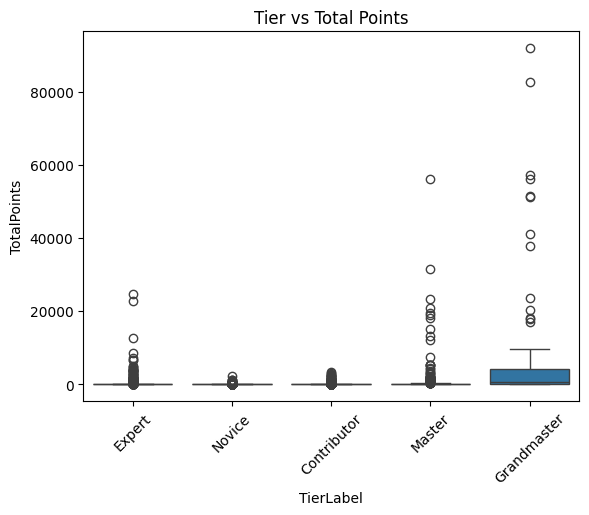

In [ ]:
sns.boxplot(data=user_feats, x='TierLabel', y='TotalPoints')
plt.xticks(rotation=45)
plt.title('Tier vs Total Points')
plt.show()

In [ ]:
user_feats.fillna({
    'TotalPoints': 0,
    'GoldMedals': 0,
    'SilverMedals': 0,
    'BronzeMedals': 0,
    'UniqueAchievementTypes': 0,
    'BestCurrentRank': -1,
    'BestHighestRank': -1
}, inplace=True)


In [ ]:
user_feats.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId,TotalPoints,GoldMedals,SilverMedals,BronzeMedals,UniqueAchievementTypes,BestCurrentRank,BestHighestRank
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,18,4,30,4,-1.0,3.0
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,15,19,160,4,1185.0,75.0
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,0,1,53,4,4086.0,82.0
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,0,0,0,4,-1.0,-1.0
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,0,0,0,4,-1.0,-1.0


In [42]:
#Feature Engineering

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
user_feats['TierEncoded'] = le.fit_transform(user_feats['TierLabel'].astype(str))


In [ ]:
user_feats.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId,TotalPoints,GoldMedals,SilverMedals,BronzeMedals,UniqueAchievementTypes,BestCurrentRank,BestHighestRank,TierEncoded
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,18,4,30,4,-1.0,3.0,5
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,15,19,160,4,1185.0,75.0,1
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,0,1,53,4,4086.0,82.0,1
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,0,0,0,4,-1.0,-1.0,4
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,0,0,0,4,-1.0,-1.0,4


In [ ]:
file_path = '/content/drive/MyDrive/META_KAGGLE/Competitions.csv'
chunk_reader = pd.read_csv(file_path, chunksize=100000)

In [ ]:
df_comp = next(chunk_reader)

In [ ]:
df_comp['EnabledDate'] = pd.to_datetime(df_comp['EnabledDate'], errors='coerce')
df_comp['Deadline'] = pd.to_datetime(df_comp['DeadlineDate'], errors='coerce')

In [ ]:
df_comp.head()

,Id,Slug,Title,Subtitle,HostSegmentTitle,ForumId,OrganizationId,EnabledDate,DeadlineDate,ProhibitNewEntrantsDeadlineDate,...,DatasetDescription,TotalCompressedBytes,TotalUncompressedBytes,ValidationSetName,ValidationSetValue,EnableSubmissionModelHashes,EnableSubmissionModelAttachments,HostName,CompetitionTypeId,Deadline
0,2408,Eurovision2010,Forecast Eurovision Voting,This competition requires contestants to forec...,Featured,2.0,NaN,2010-04-07 07:57:43,05/25/2010 18:00:00,NaN,...,# Dataset Description\n\n<p><b>Data provided<b...,800614.0,400307.0,NaN,NaN,False,False,NaN,1,2010-05-25 18:00:00
1,2435,hivprogression,Predict HIV Progression,This contest requires competitors to predict t...,Featured,1.0,NaN,2010-04-27 21:29:09,08/02/2010 12:32:00,NaN,...,# Dataset Description\n\n<div><div><div>These ...,2141503.0,1095096.0,NaN,NaN,False,False,NaN,1,2010-08-02 12:32:00
2,2438,worldcup2010,World Cup 2010 - Take on the Quants,Quants at Goldman Sachs and JP Morgan have mod...,Featured,3094129.0,NaN,2010-06-03 08:08:08,06/11/2010 13:29:00,NaN,...,# Dataset Description\n\n<p>We have provided a...,10401.0,10401.0,NaN,NaN,False,False,NaN,1,2010-06-11 13:29:00
3,2439,informs2010,INFORMS Data Mining Contest 2010,The goal of this contest is to predict short t...,Featured,4.0,NaN,2010-06-21 21:53:25,10/10/2010 02:28:00,NaN,...,"# Dataset Description\n\n<div><span class=""App...",14718207.0,14718207.0,NaN,NaN,False,False,NaN,1,2010-10-10 02:28:00
4,2442,worldcupconf,World Cup 2010 - Confidence Challenge,The Confidence Challenge requires competitors ...,Featured,3.0,NaN,2010-06-03 08:08:08,06/11/2010 13:28:00,NaN,...,# Dataset Description\n\n<p>We have provided a...,NaN,NaN,NaN,NaN,False,False,NaN,1,2010-06-11 13:28:00


In [ ]:
df_comp['CompDuration'] = (df_comp['Deadline'] - df_comp['EnabledDate']).dt.days


In [ ]:
organizer_feats = df_comp.groupby('Id').agg({
    'Id': 'count',  # Number of competitions hosted
    'RewardQuantity': ['mean', 'sum', 'max'],
    'CompDuration': ['mean', 'max']
}).reset_index()

In [ ]:
organizer_feats.columns = ['UserId',
                           'NumCompetitionsHosted',
                           'AvgReward', 'TotalReward', 'MaxReward',
                           'AvgCompDuration', 'MaxCompDuration']

In [ ]:
user_feats = user_feats.merge(organizer_feats, how='left', left_on='Id', right_on='UserId')

In [ ]:
#user_feats.drop(columns=['Id'], inplace=True)


In [ ]:
user_feats.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId_x,TotalPoints,...,BestCurrentRank,BestHighestRank,TierEncoded,UserId_y,NumCompetitionsHosted,AvgReward,TotalReward,MaxReward,AvgCompDuration,MaxCompDuration
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,...,-1.0,3.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,...,1185.0,75.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,...,4086.0,82.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,...,-1.0,-1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,...,-1.0,-1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

user_feats[['NumCompetitionsHosted', 'AvgReward', 'TotalReward',
            'MaxReward', 'AvgCompDuration', 'MaxCompDuration']] = user_feats[
    ['NumCompetitionsHosted', 'AvgReward', 'TotalReward',
     'MaxReward', 'AvgCompDuration', 'MaxCompDuration']
].fillna(0)


In [ ]:
submissions_chunks = pd.read_csv("/content/drive/MyDrive/META_KAGGLE/Submissions.csv", chunksize=100000)


In [ ]:
df_submissions = pd.concat(submissions_chunks)

<ipython-input-113-478411829>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_submissions = pd.concat(submissions_chunks)


In [ ]:
submissions_chunks = pd.read_csv("/content/drive/MyDrive/META_KAGGLE/Submissions.csv",
                                 chunksize=100000,
                                 dtype={'Status': str},  # Adjust types explicitly if needed
                                 na_values=['None', 'null', 'NULL', ''])

In [ ]:
df_submissions['PublicScoreFullPrecision'] = pd.to_numeric(df_submissions['PublicScoreFullPrecision'], errors='coerce')
df_submissions['PrivateScoreFullPrecision'] = pd.to_numeric(df_submissions['PrivateScoreFullPrecision'], errors='coerce')


In [ ]:
df_submissions.head()

,Id,SubmittedUserId,TeamId,SourceKernelVersionId,SubmissionDate,ScoreDate,IsAfterDeadline,IsSelected,PublicScoreLeaderboardDisplay,PublicScoreFullPrecision,PrivateScoreLeaderboardDisplay,PrivateScoreFullPrecision
0,2180,647.0,496,NaN,04/29/2010,NaN,False,False,55.76919,55.769199,56.21390,56.213902
1,2181,619.0,497,NaN,04/30/2010,NaN,False,False,47.11539,47.115398,50.00000,50.000000
2,2182,619.0,497,NaN,04/30/2010,NaN,False,False,61.05770,61.057701,65.60690,65.606903
3,2184,663.0,499,NaN,05/01/2010,NaN,False,False,47.11539,47.115398,50.00000,50.000000
4,2185,673.0,500,NaN,05/02/2010,NaN,False,False,61.05770,61.057701,62.28319,62.283199


In [ ]:
submission_stats = df_submissions.groupby("SubmittedUserId").agg(
    NumSubmissions=('Id', 'count'),
    BestPublicScore=('PublicScoreFullPrecision', 'min'),
    AvgPublicScore=('PublicScoreFullPrecision', 'mean'),
    BestPrivateScore=('PrivateScoreFullPrecision', 'min'),
    AvgPrivateScore=('PrivateScoreFullPrecision', 'mean')
).reset_index()

In [ ]:
user_feats = user_feats.merge(submission_stats, how='left', left_on='Id', right_on='SubmittedUserId')


In [ ]:
user_feats.drop(columns=['SubmittedUserId'], inplace=True)

In [ ]:
user_feats[['NumSubmissions', 'BestPublicScore', 'AvgPublicScore', 'BestPrivateScore', 'AvgPrivateScore']] = \
    user_feats[['NumSubmissions', 'BestPublicScore', 'AvgPublicScore', 'BestPrivateScore', 'AvgPrivateScore']].fillna(0)

In [ ]:
user_feats.head()


,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId_x,TotalPoints,...,AvgReward,TotalReward,MaxReward,AvgCompDuration,MaxCompDuration,NumSubmissions,BestPublicScore,AvgPublicScore,BestPrivateScore,AvgPrivateScore
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,...,0.0,0.0,0.0,0.0,0.0,78.0,-0.006722,6.385148,-0.000895,6.493357
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.024876,0.759243,0.017241,0.814674
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
kernels_chunks = pd.read_csv(
    "/content/drive/MyDrive/META_KAGGLE/Kernels.csv",
    chunksize=100000,
    na_values=['None', 'null', ''],
    low_memory=False
)

In [ ]:
df_kernels = pd.concat(kernels_chunks)

In [ ]:
df_kernels['EvaluationDate'] = pd.to_datetime(df_kernels['EvaluationDate'], errors='coerce')


In [ ]:
kernel_stats = df_kernels.groupby("AuthorUserId").agg(
    NumKernels=('Id', 'count'),
    TotalKernelVotes=('TotalVotes', 'sum'),
    AvgKernelScore=('TotalVotes', 'mean')  # or use another score column if available
).reset_index()

In [ ]:
user_feats = user_feats.merge(kernel_stats, how='left', left_on='Id', right_on='AuthorUserId')


In [ ]:
user_feats.drop(columns=['AuthorUserId'], inplace=True)


In [ ]:
user_feats[['NumKernels', 'TotalKernelVotes', 'AvgKernelScore']] = \
    user_feats[['NumKernels', 'TotalKernelVotes', 'AvgKernelScore']].fillna(0)


In [ ]:
user_feats.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId_x,TotalPoints,...,AvgCompDuration,MaxCompDuration,NumSubmissions,BestPublicScore,AvgPublicScore,BestPrivateScore,AvgPrivateScore,NumKernels,TotalKernelVotes,AvgKernelScore
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,...,0.0,0.0,78.0,-0.006722,6.385148,-0.000895,6.493357,186.0,430.0,2.311828
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,...,0.0,0.0,16.0,0.024876,0.759243,0.017241,0.814674,0.0,0.0,0.000000
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [ ]:
user_feats.to_csv("/content/drive/MyDrive/META_KAGGLE/final_user_feats.csv", index=False)


In [ ]:
pd.read_csv("/content/drive/MyDrive/META_KAGGLE/final_user_feats.csv").head()


,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,TierLabel,AccountAge,UserId_x,TotalPoints,...,AvgCompDuration,MaxCompDuration,NumSubmissions,BestPublicScore,AvgPublicScore,BestPrivateScore,AvgPrivateScore,NumKernels,TotalKernelVotes,AvgKernelScore
0,1,kaggleteam,Kaggle Team,2011-03-24,5,Unknown,NaN,5199,1,646,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,2,United States,Expert,5627,368,86,...,0.0,0.0,78.0,-0.006722,6.385148,-0.000895,6.493357,186.0,430.0,2.311828
2,381,iguyon,Isabelle,2010-01-29,2,United States,Expert,5618,381,0,...,0.0,0.0,16.0,0.024876,0.759243,0.017241,0.814674,0.0,0.0,0.000000
3,383,davidstephan,David Stephan,2010-02-01,0,Australia,Novice,5615,383,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,384,gabewarren,Gabe Warren,2010-02-02,0,Australia,Novice,5614,384,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [12]:
user_feats = pd.read_csv(r"C:\Users\DELL\Documents\final_user_feats.csv")

In [1]:
import pandas as pd

In [4]:
fp = r"C:\Users\DELL\Downloads\KernelVersions.csv"

In [5]:
chunks = pd.read_csv(fp, chunksize=100000, low_memory=False)

In [6]:
df_kernel_versions = pd.concat(chunks)

In [7]:
df_kernel_versions.head()

,Id,ScriptId,ParentScriptVersionId,ScriptLanguageId,AuthorUserId,CreationDate,VersionNumber,Title,EvaluationDate,IsChange,...,LinesUnchangedFromPrevious,LinesInsertedFromFork,LinesDeletedFromFork,LinesChangedFromFork,LinesUnchangedFromFork,TotalVotes,IsInternetEnabled,RunningTimeInMilliseconds,AcceleratorTypeId,DockerImage
0,722456,112370,NaN,9,368,01/18/2017 01:45:51,36.0,Calculate Velocity Made Good (VMG),01/18/2017,True,...,400.0,NaN,NaN,NaN,NaN,0,False,43866.0,0,NaN
1,349108,58777,NaN,2,527964,08/31/2016 22:37:53,47.0,Titanic,08/31/2016,False,...,43.0,NaN,NaN,NaN,NaN,0,False,2422.0,0,NaN
2,357119,58777,NaN,2,527964,09/08/2016 22:51:27,60.0,Titanic,09/08/2016,False,...,41.0,NaN,NaN,NaN,NaN,0,False,1965.0,0,NaN
3,335015,58777,NaN,2,527964,08/18/2016 22:51:27,22.0,Titanic,08/18/2016,False,...,31.0,NaN,NaN,NaN,NaN,0,False,6720.0,0,NaN
4,307632,81167,NaN,9,527964,07/23/2016 18:34:13,6.0,Talk Talk,07/23/2016,True,...,18.0,NaN,NaN,NaN,NaN,0,False,42653.0,0,NaN


In [8]:
kernel_stats = df_kernel_versions.groupby("AuthorUserId").agg(
    NumKernels=('Id', 'count'),
    TotalKernelVotes=('TotalVotes', 'sum'),
    AvgKernelScore=('TotalVotes', 'mean')
).reset_index()

In [13]:
user_feats = user_feats.merge(kernel_stats, how='left', left_on='Id', right_on='AuthorUserId')

C:\Users\DELL\AppData\Local\Temp\ipykernel_15384\2298778730.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TotalKernelVotes_x', 'NumKernels_x', 'AvgKernelScore_x'} in the result is deprecated and will raise a MergeError in a future version.
  user_feats = user_feats.merge(kernel_stats, how='left', left_on='Id', right_on='AuthorUserId')


In [15]:
print("Columns in KernelVersions:", df_kernel_versions.columns.tolist())
print(df_kernel_versions[['AuthorUserId', 'TotalVotes']].head())

Columns in KernelVersions: ['Id', 'ScriptId', 'ParentScriptVersionId', 'ScriptLanguageId', 'AuthorUserId', 'CreationDate', 'VersionNumber', 'Title', 'EvaluationDate', 'IsChange', 'TotalLines', 'LinesInsertedFromPrevious', 'LinesChangedFromPrevious', 'LinesUnchangedFromPrevious', 'LinesInsertedFromFork', 'LinesDeletedFromFork', 'LinesChangedFromFork', 'LinesUnchangedFromFork', 'TotalVotes', 'IsInternetEnabled', 'RunningTimeInMilliseconds', 'AcceleratorTypeId', 'DockerImage']
   AuthorUserId  TotalVotes
0           368           0
1        527964           0
2        527964           0
3        527964           0
4        527964           0


In [16]:
kernel_stats = df_kernel_versions.groupby("AuthorUserId").agg(
    NumKernels=('Id', 'count'),
    TotalKernelVotes=('TotalVotes', 'sum'),
    AvgKernelScore=('TotalVotes', 'mean')
).reset_index()

In [17]:
user_feats = user_feats.merge(kernel_stats, how='left', left_on='Id', right_on='AuthorUserId')


In [18]:
user_feats[['NumKernels', 'TotalKernelVotes', 'AvgKernelScore']] = \
    user_feats[['NumKernels', 'TotalKernelVotes', 'AvgKernelScore']].fillna(0)


In [19]:
user_feats.to_csv("final_userfeats.csv", index=False)

In [20]:
user_feats.to_csv(r"C:\Users\DELL\Downloads\final_userfeats.csv", index=False)


In [21]:
columns_to_drop = [
    'NumKernels_x', 'TotalKernelVotes_x', 'AvgKernelScore_x',
    'NumKernels_y', 'TotalKernelVotes_y', 'AvgKernelScore_y',
    'AuthorUserId', 'UserId_x'
]

In [22]:
user_feats_cleaned = user_feats.drop(columns=columns_to_drop, errors='ignore')

In [23]:
user_feats_cleaned = user_feats_cleaned.fillna(0)

In [24]:
user_feats_cleaned.to_csv(r"C:\Users\DELL\Documents\final_cleaned_user_feats.csv", index=False)

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [26]:
df = pd.read_csv(r"C:\Users\DELL\Documents\final_cleaned_user_feats.csv")
user_ids = df['Id']
features = df.drop(columns=['Id', 'UserName', 'DisplayName', 'RegisterDate', 'Country', 'TierLabel'])


In [27]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

In [28]:
nn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 6 because 1 will be the user itself
nn.fit(scaled)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [29]:
distances, indices = nn.kneighbors(scaled)

In [43]:
## Cosine Similarity Calculation

results = []
for idx, user_id in enumerate(user_ids):
    for sim_idx, dist in zip(indices[idx][1:], distances[idx][1:]):  # skip self
        results.append({
            'UserId': user_id,
            'SimilarUserId': user_ids.iloc[sim_idx],
            'SimilarityScore': 1 - dist  # cosine similarity = 1 - distance
        })

In [31]:
similar_users_df = pd.DataFrame(results)

In [ ]:
similar_users_df.to_csv(r"C:\Users\DELL\Documents\top_similar_users.csv", index=False)

In [32]:
similar_users_df.sort_values(['UserId', 'SimilarityScore'], ascending=[True, False]).head(10)

,UserId,SimilarUserId,SimilarityScore
0,1,2505,0.994670
1,1,3258,0.974332
2,1,22991,0.966136
3,1,8574,0.965675
4,1,8507,0.965656
5,368,650,0.969461
6,368,993,0.961186
7,368,3716,0.946239
8,368,2036,0.945609
9,368,1240,0.943803


In [33]:
similar_users_df.head()

,UserId,SimilarUserId,SimilarityScore
0,1,2505,0.994670
1,1,3258,0.974332
2,1,22991,0.966136
3,1,8574,0.965675
4,1,8507,0.965656


In [34]:
import pandas as pd

user_feats = pd.read_csv(r"C:\Users\DELL\Documents\final_cleaned_user_feats.csv")
similar_users = pd.read_csv(r"C:\Users\DELL\Documents\top_similar_users.csv")

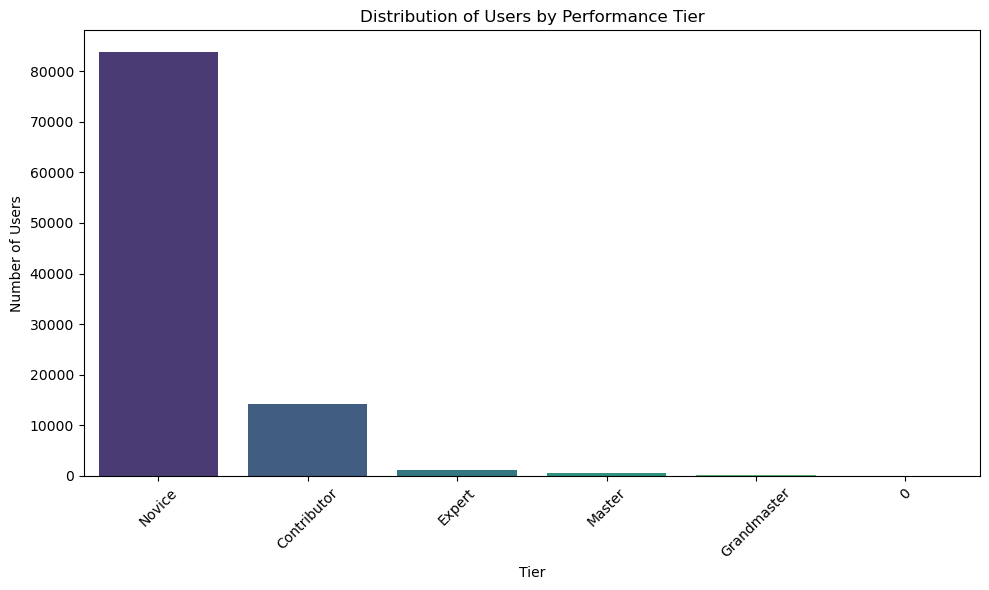

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=user_feats, x='TierLabel', order=user_feats['TierLabel'].value_counts().index, palette='viridis')
plt.title("Distribution of Users by Performance Tier")
plt.xlabel("Tier")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


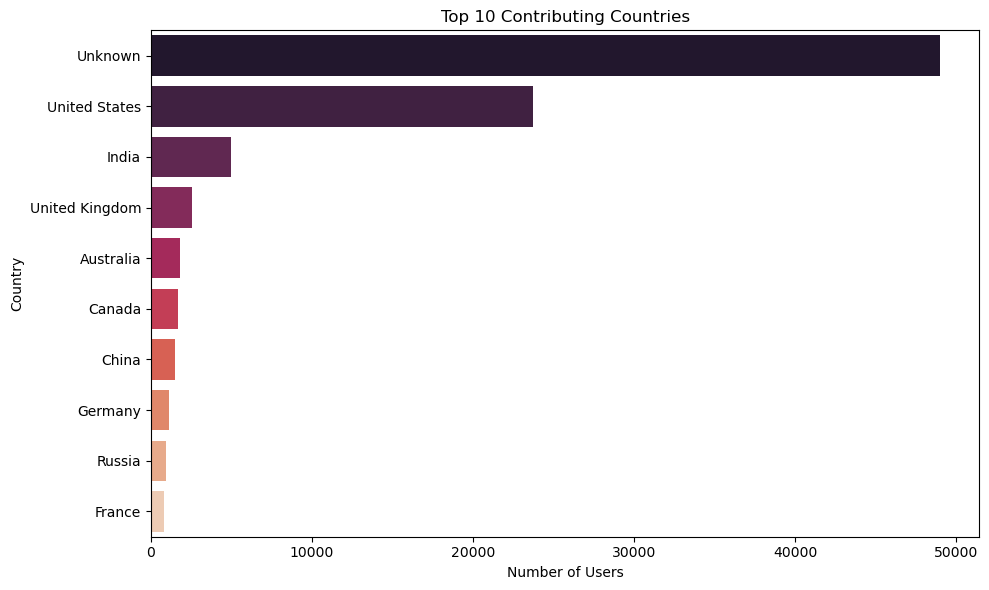

In [36]:
top_countries = user_feats['Country'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="rocket")
plt.title("Top 10 Contributing Countries")
plt.xlabel("Number of Users")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


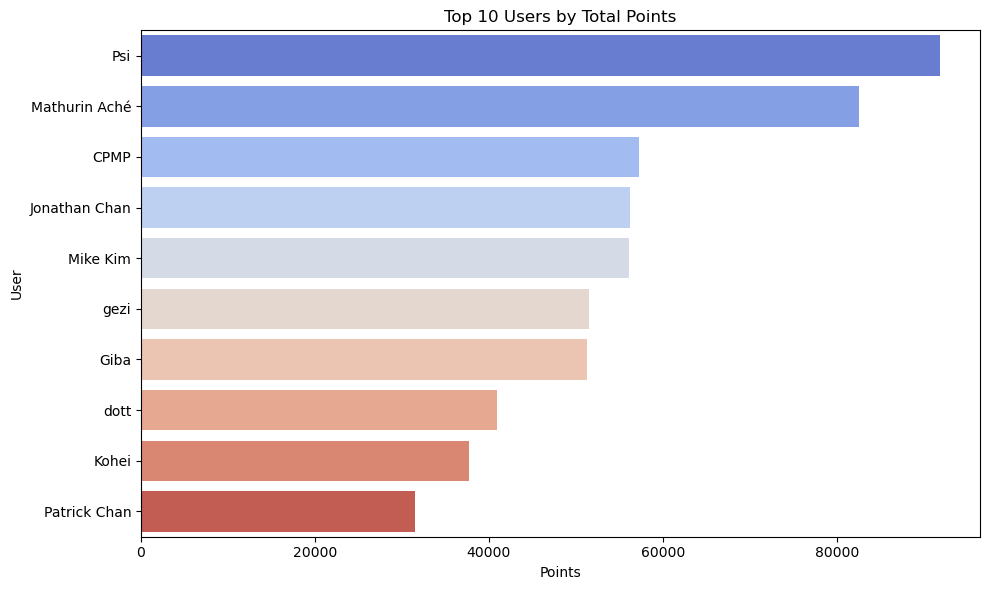

In [37]:
top_users = user_feats[['DisplayName', 'TotalPoints']].sort_values(by='TotalPoints', ascending=False).dropna().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='TotalPoints', y='DisplayName', data=top_users, palette='coolwarm')
plt.title("Top 10 Users by Total Points")
plt.xlabel("Points")
plt.ylabel("User")
plt.tight_layout()
plt.show()

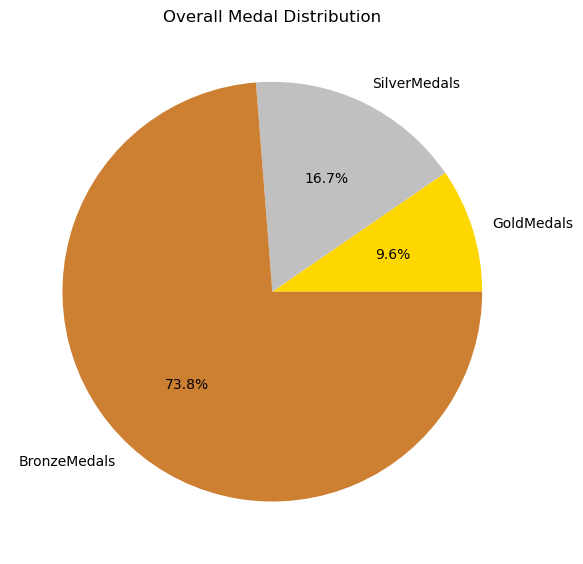

In [38]:
medal_totals = user_feats[['GoldMedals', 'SilverMedals', 'BronzeMedals']].sum()

plt.figure(figsize=(6,6))
plt.pie(medal_totals, labels=medal_totals.index, autopct='%1.1f%%', colors=['#FFD700','#C0C0C0','#CD7F32'])
plt.title("Overall Medal Distribution")
plt.tight_layout()
plt.show()


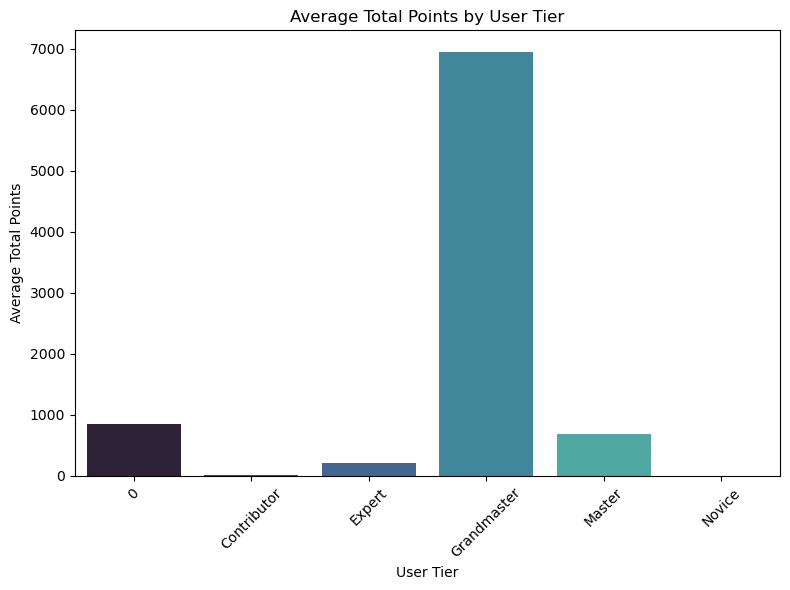

In [39]:
tier_avg = user_feats.groupby('TierLabel')['TotalPoints'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(data=tier_avg, x='TierLabel', y='TotalPoints', palette='mako')
plt.title("Average Total Points by User Tier")
plt.xlabel("User Tier")
plt.ylabel("Average Total Points")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

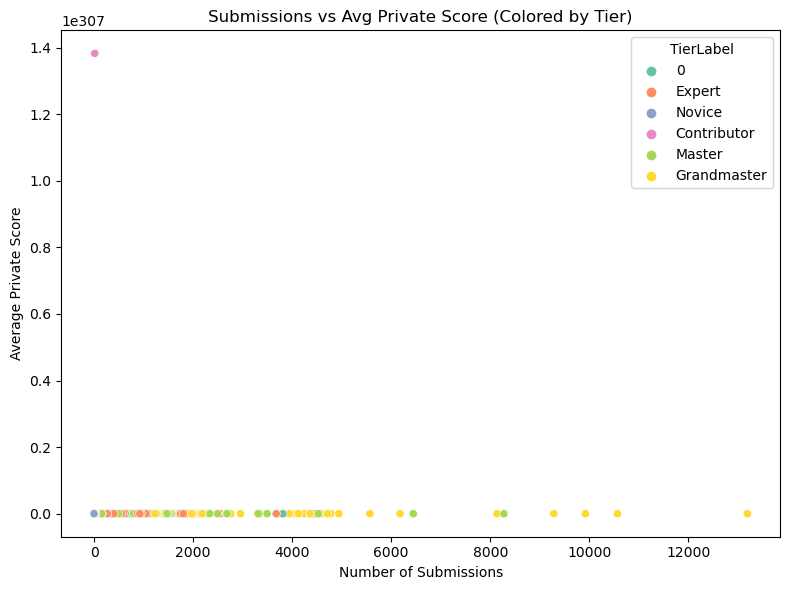

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=user_feats, x='NumSubmissions', y='AvgPrivateScore', hue='TierLabel', palette='Set2')
plt.title("Submissions vs Avg Private Score (Colored by Tier)")
plt.xlabel("Number of Submissions")
plt.ylabel("Average Private Score")
plt.tight_layout()
plt.show()


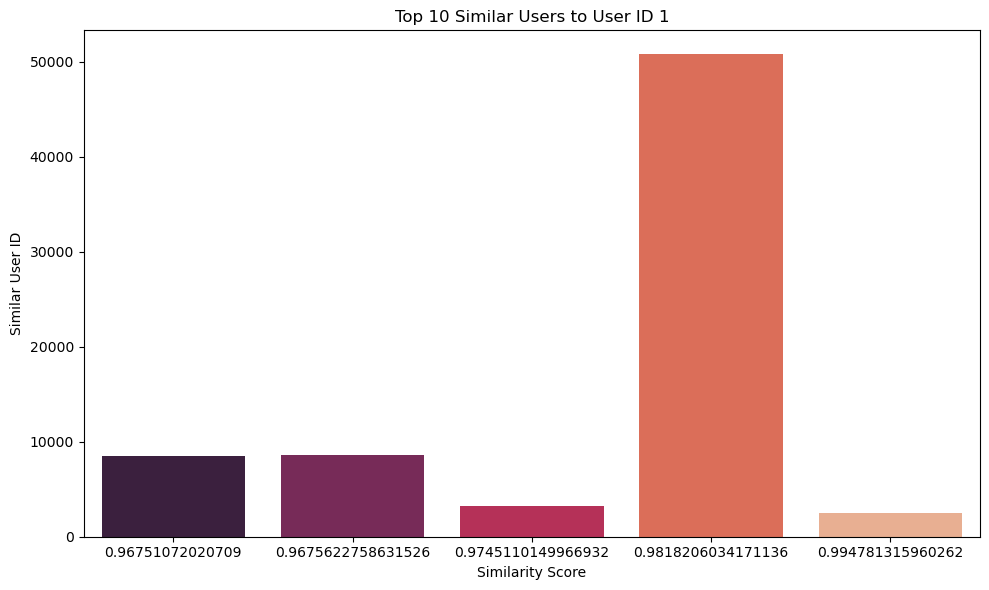

In [41]:
user_id = 1  # you can loop over others later
similar_users = similar_users[similar_users['UserId'] == user_id].sort_values(by='SimilarityScore', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=similar_users, x='SimilarityScore', y='SimilarUserId', palette='rocket')
plt.title(f"Top 10 Similar Users to User ID {user_id}")
plt.xlabel("Similarity Score")
plt.ylabel("Similar User ID")
plt.tight_layout()
plt.show()
